---
#   **LRS**
---

## **Import Libraries**

In [3]:
import os
import cv2
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from PIL.TiffTags import TAGS
import pandas as pd

## **Define Paths**

In [4]:
main_image_path = "./dataset/20241014aC0822230w275445n.tif"
mask_path = "./mask-semantic/train/tile_9_jpg.rf.d7787040bfb812b5c96c58b53fef6be3_mask.png"

## **Check the MetaData of Main Image**

In [5]:
def get_tiff_metadata(image_path):
    image = Image.open(image_path)

    metadata = {}
    for tag, value in image.tag_v2.items():
        tag_name = TAGS.get(tag, tag)
        metadata[tag] = (tag_name, value)
    return metadata

image_path = main_image_path
metadata = get_tiff_metadata(image_path)
for tag, (tag_name, value) in metadata.items():
    print(f"Tag {tag} ({tag_name}): {value}")

Tag 256 (ImageWidth): 4707
Tag 257 (ImageLength): 4707
Tag 258 (BitsPerSample): (8, 8, 8)
Tag 259 (Compression): 7
Tag 322 (TileWidth): 512
Tag 323 (TileLength): 512
Tag 262 (PhotometricInterpretation): 6
Tag 324 (TileOffsets): (3680375, 3777342, 3874539, 3974094, 4067887, 4163194, 4260106, 4346861, 4421322, 4504248, 4543545, 4636357, 4744646, 4839237, 4937669, 5033638, 5131866, 5223846, 5323384, 5421219, 5467834, 5567045, 5666985, 5778154, 5873792, 5969234, 6070526, 6170798, 6269636, 6360653, 6412534, 6504994, 6588720, 6679546, 6774604, 6868877, 6961875, 7057827, 7149566, 7241186, 7287588, 7383497, 7479058, 7562464, 7662875, 7765199, 7865158, 7960415, 8059860, 8157478, 8204487, 8304118, 8402523, 8489859, 8592679, 8692619, 8792532, 8893842, 8980820, 9076774, 9126317, 9230001, 9336271, 9432219, 9532308, 9632017, 9733621, 9831860, 9927145, 10020012, 10071258, 10181498, 10289485, 10400410, 10506585, 10611864, 10710707, 10811044, 10911466, 11007177, 11054400, 11154126, 11258533, 11369547, 

## **Extract GSD from Main Image**

### **Ground Sampling Distance (GSD) Calculation:**
- Purpose: Converts pixel measurements to real-world distances
- Formula: 
```
meters_per_degree_lat = 111319.9  # Earth's circumference / 360°
meters_per_degree_lon = meters_per_degree_lat * cos(latitude)
gsd_x = pixel_scale_x * meters_per_degree_lon
gsd_y = pixel_scale_y * meters_per_degree_lat
```

In [6]:
main_image_path = main_image_path
with Image.open(main_image_path) as img:
    metadata = img.tag_v2
    model_pixel_scale = metadata.get(33550)
    pixel_scale_x, pixel_scale_y = model_pixel_scale[0], model_pixel_scale[1]
    latitude = metadata.get(33922)[4]
    meters_per_degree_lat = 111319.9
    meters_per_degree_lon = meters_per_degree_lat * math.cos(math.radians(latitude))
    gsd_x = pixel_scale_x * meters_per_degree_lon
    gsd_y = pixel_scale_y * meters_per_degree_lat

## **Calculate the Pixel of road**

### **Description of the Code**
The code performs the following steps:

1. **Load the Mask Image**: Reads the road mask image in grayscale using OpenCV (`cv2.imread`).
2. **Convert to Binary Mask**: Converts the grayscale image into a binary mask where road pixels are assigned `1`, and non-road pixels are `0`.
3. **Calculate Pixel Statistics**:
   - Counts the total number of road pixels.
   - Counts the total number of non-road pixels.
   - Calculates the total number of pixels in the image.
4. **Identify Connected Components**:
   - Uses `cv2.connectedComponents()` to label each separate connected road component in the binary mask.
5. **Create a Colored Mask for Visualization**:
   - Initializes an empty color mask.
   - Iterates through each connected component (excluding the background).
   - Assigns each connected road component a unique random color.
6. **Generate an Output Image**:
   - Converts the colored mask into a format suitable for display (`BGR` format).
   - Places labels on each identified road component at their centroid using `cv2.putText()`.

### **Techniques Used in the Code**
#### 1. **Image Processing with OpenCV**
   - **Grayscale Conversion** (`cv2.IMREAD_GRAYSCALE`): Reads the image in a single channel (black & white) format.
   - **Binary Masking**: Converts pixel values into a binary format (`1` for road, `0` for non-road).
   - **Connected Components Analysis** (`cv2.connectedComponents`): Identifies and labels separate connected regions.
   - **Color Masking**: Creates a 3-channel (RGB) image where each detected road component gets a random color.
   - **Text Annotation** (`cv2.putText`): Writes text labels on detected road regions.

#### 2. **Mathematical & Computer Vision Techniques**
   - **Binary Thresholding**: Converts the grayscale image into a binary format.
   - **Connected Component Labeling**: A fundamental technique in computer vision for segmenting distinct objects.
   - **Statistical Analysis**: Computes the number of pixels in road and non-road areas.
   - **Centroid Calculation**: Uses `np.argwhere().mean(axis=0)` to compute the mean position (centroid) of each road component.

#### 3. **Randomized Coloring for Visualization**
   - **`np.random.randint(100, 255)`**: Generates random colors within a bright range to distinguish road segments.
   - Ensures that each connected road component appears uniquely colored for easy identification.


In [7]:
mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

binary_mask = (mask_img > 0).astype(np.uint8)

total_road_pixels = np.sum(binary_mask == 1)
total_non_road_pixels = np.sum(binary_mask == 0)
total_pixels = binary_mask.size 

num_labels, labels = cv2.connectedComponents(binary_mask)

colored_mask = np.zeros((mask_img.shape[0], mask_img.shape[1], 3), dtype=np.uint8)

road_pixel_counts = {}
for label in range(1, num_labels):  
    road_pixels = np.sum(labels == label)
    road_pixel_counts[label] = road_pixels
    
    colored_mask[labels == label] = [np.random.randint(100, 255), np.random.randint(100, 255), np.random.randint(100, 255)]

output_image = cv2.cvtColor(colored_mask, cv2.COLOR_RGB2BGR)


for label in range(1, num_labels):
    y, x = np.argwhere(labels == label).mean(axis=0).astype(int) 
    cv2.putText(output_image, f"Road {label}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (255, 255, 255), 2, cv2.LINE_AA)

## **Computation of Road Dimensions from Image and Conversion to Real-World Measurements**
### **Description of the Code**
- This code **analyzes the size and shape of each road component** in a segmented road mask.
- It first **computes road dimensions in pixels** and then **converts them into real-world measurements (meters)** using **Ground Sample Distance (GSD)**.
- The output provides a dictionary containing:
  - **Average horizontal width (pixels & meters)**
  - **Average vertical height (pixels & meters)**
  - **Widest section (min of horizontal & vertical distances, in pixels & meters)**
  - *(Optional: Length measurement using `max()` is commented out but available if needed.)*
- Converts **road dimensions from pixels to meters** using **GSD values** (`gsd_x`, `gsd_y`).
- Outputs real-world values for **road width and height**.
- The calculation assumes **an orthogonal view**, where `gsd_x` and `gsd_y` represent actual distances in meters.
- The road width and (optional) length are stored in the `road_dimensions` dictionary.

### **Techniques Used**
#### 1. **Connected Component Analysis**
   - The `labels` array obtained from `cv2.connectedComponents()` assigns a unique integer label to each connected road component.
   - The code extracts dimensions for each labeled region.

#### 2. **Pixel Distance Calculation**
   - **Horizontal width**: Measures the difference between the leftmost and rightmost pixels in each row.
   - **Vertical height**: Measures the difference between the topmost and bottom-most pixels in each column.
   - Uses `np.where(labels[row] == label)[0]` to find pixel positions.

#### 3. **Statistical Analysis**
   - **Mean Calculation (`np.mean`)**:
     - Averages horizontal and vertical distances to approximate road dimensions.
   - **Min-Max Width & Length (`min/max`)**:
     - Determines the smaller dimension as **"wide"** and the larger one as **"length"**.
#### 4. **Ground Sample Distance (GSD) Conversion**
   - **GSD** represents the **real-world size of a single pixel** in meters.
   - `gsd_x`: Horizontal GSD (meters per pixel in x-direction).
   - `gsd_y`: Vertical GSD (meters per pixel in y-direction).
   - Each pixel measurement is multiplied by the respective GSD to convert pixel distances into real-world meters.

#### 5. **Min-Max Dimension Selection**
   - **Width Calculation (`min()`)**:
     - The narrowest dimension is assigned as the **width** of the road.
   - **Length Calculation (`max()`, commented out)**:
     - The longest dimension would be the **length** of the road.


In [ ]:

road_dimensions = {}
for label in range(1, num_labels):  # ignoring background (label 0)
    # Horizontal distances (row-wise)
    horizontal_distances = []
    for row in range(labels.shape[0]):
        indices = np.where(labels[row] == label)[0]
        if indices.size > 0:
            horizontal_distances.append(indices[-1] - indices[0])
    avg_horizontal = np.mean(horizontal_distances) if horizontal_distances else 0

    # Vertical distances (column-wise)
    vertical_distances = []
    for col in range(labels.shape[1]):
        indices = np.where(labels[:, col] == label)[0]
        if indices.size > 0:
            vertical_distances.append(indices[-1] - indices[0])
    avg_vertical = np.mean(vertical_distances) if vertical_distances else 0

    wide = min(avg_horizontal, avg_vertical)
    length = max(avg_horizontal, avg_vertical)
    
    road_dimensions[label] = {
        "avg_horizontal_pixel": avg_horizontal,
        "avg_vertical_pixel": avg_vertical,
        "wide_pixel": wide,
        # "length": length
    }

for label in road_dimensions:
    road_dimensions[label]['avg_horizontal_meter'] = road_dimensions[label]['avg_horizontal_pixel'] * gsd_x
    road_dimensions[label]['avg_vertical_meter'] = road_dimensions[label]['avg_vertical_pixel'] * gsd_y
    road_dimensions[label]['width in Meter'] = min(road_dimensions[label]['avg_horizontal_meter'], road_dimensions[label]['avg_vertical_meter'])
    # road_dimensions[label]['length_m'] = max(road_dimensions[label]['avg_horizontal_m'], road_dimensions[label]['avg_vertical_m'])

# Outcome

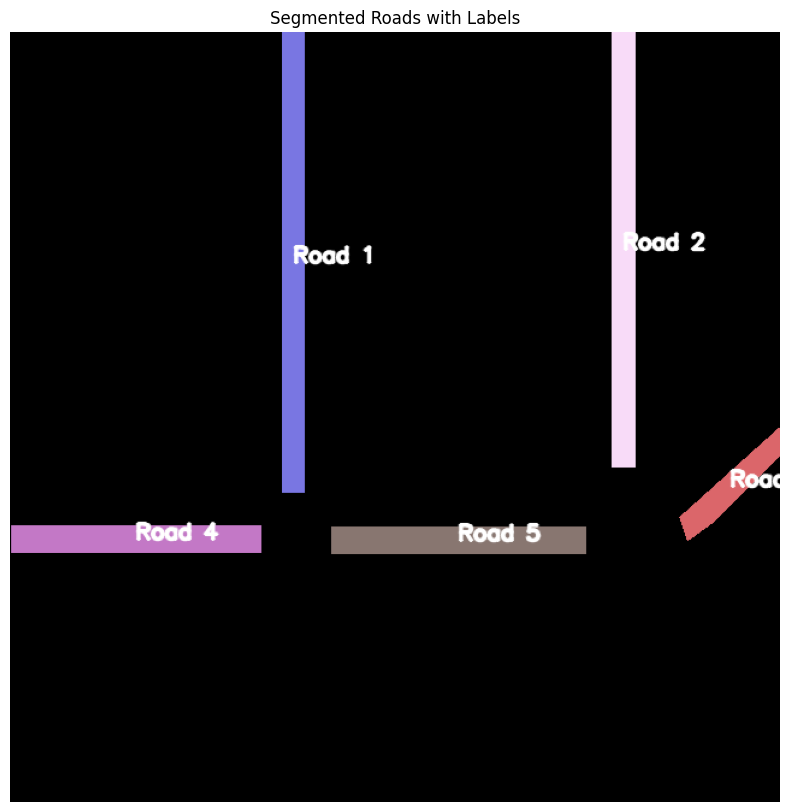

=== Road Pixel Counts (Per Road) ===
 Road  Pixel Count
    1         7277
    2         7240
    3         2206
    4         4784
    5         4876

=== Road Dimensions (Horizontal and Vertical) ===
      avg_horizontal_pixel  avg_vertical_pixel  wide_pixel
Road                                                      
1                18.000000          382.000000   18.000000
2                19.000000          361.000000   19.000000
3                22.468085           25.261905   22.468085
4               207.000000           22.000000   22.000000
5               211.000000           22.000000   22.000000

=== Road Dimensions (Horizontal and Vertical) ===
Empty DataFrame
Columns: []
Index: []
Latitude extracted for GSD calculation: 27.9125986509454
meters_per_degree_lat: 111319.9, meters_per_degree_lon: 98369.24524576397
Ground Sampling Distance (GSD) calculated: gsd_x = 0.2654109655028968, gsd_y = 0.3003532462290768


In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Roads with Labels")
plt.axis("off")
plt.show()

print("===============================================================================================")
df_pixel_counts = pd.DataFrame(list(road_pixel_counts.items()), columns=["Road", "Pixel Count"])
print("=== Road Pixel Counts (Per Road) ===")
print(df_pixel_counts.to_string(index=False))

print("===============================================================================================")
df_road_dimensions = pd.DataFrame.from_dict(road_dimensions, orient="index")
df_road_dimensions.index.name = "Road"
print("\n=== Road Dimensions (Horizontal and Vertical) ===")
print(df_road_dimensions.to_string())

print("===============================================================================================")
print("Latitude extracted for GSD calculation:", latitude)
print(f"meters_per_degree_lat: {meters_per_degree_lat}, meters_per_degree_lon: {meters_per_degree_lon}")
print(f"Ground Sampling Distance (GSD) calculated: gsd_x = {gsd_x}, gsd_y = {gsd_y}")
